# Creates various benchmarks/baseline measures for GDP growth  / change

### Phase 1: Create Baselines
In this script, we create baseline forecasts for GDP change metrics of all countries for the year 2022 in 3 different ways:
1. Using T-1 prediction (repeat 2021 value) for 2022
2. Using expert prediction: by taking as given values from human experts (eg. IMF and World Bank)
3. Using a simple average of the last 10 years
4. Using an xgboost model trained on data from 2001 to 2020 to predict 2021

### Phase 2: Create error metrics
Compare how the LLM forecast compares to these 3 metrics

### Phase 3: Visualize results
Compare performance in tables, plots

## Setup

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [21]:
from sklearn.linear_model import LinearRegression

In [22]:
from datetime import datetime

now = datetime.now() # current date and time
now_folder = now.strftime("%Y%m%d_%H%M")
date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
print("results saved to:",now_folder)

results saved to: 20231205_0431


In [23]:
!mkdir $now_folder

### Parameters

In [24]:
PREDICTION_HORIZON = 1

In [25]:
finetuned_results_df = pd.read_csv('test_cleaned_gdp_growth_finetuned_predictions_' + str(PREDICTION_HORIZON) + 'yr.csv')
cleaned_gdp_growth_countries = pd.read_csv('cleaned_gdp_growth_df.csv')
rounded_gdp_growth_df = pd.read_csv('rounded_cleaned_gdp_growth_df.csv')
zero_shot_results_df = pd.read_csv('test_cleaned_gdp_growth_zero_shot_predictions_1yr.csv')

In [26]:
PREDICTION_YEAR = '2022'

In [27]:
# drop any rows with nan values
print(zero_shot_results_df.shape[0])
print(finetuned_results_df.shape[0])
print(cleaned_gdp_growth_countries.shape[0])
print(rounded_gdp_growth_df.shape[0])

182
182
196
182


In [28]:
zero_shot_results_df.head()

,country,predicted_gdp,observed_gdp
0,Albania,6.1,4.8
1,Algeria,4.3,3.2
2,Angola,4.5,3.0
3,Antigua and Barbuda,5.2,8.5
4,Argentina,2.5,5.0


In [29]:
rounded_gdp_growth_df.head()

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2020,2021,2022,2023,2024,2025,2026,2027,2028,country
0,2.7,5.7,2.9,1.1,2.0,-1.5,5.6,-0.8,-1.4,9.8,...,-3.3,8.9,4.8,3.6,3.3,3.4,3.5,3.5,3.5,Albania
1,-5.4,3.0,6.4,5.4,5.6,5.6,-0.2,-0.7,-1.9,4.8,...,-5.1,3.4,3.2,3.8,3.1,2.5,1.9,1.7,1.7,Algeria
2,2.4,-4.4,0.0,4.2,6.0,3.5,2.9,4.1,6.1,0.0,...,-5.6,1.2,3.0,1.3,3.3,3.4,3.5,3.5,3.6,Angola
3,8.2,3.8,-0.1,5.4,10.2,7.6,11.5,6.6,5.2,5.3,...,-17.5,6.6,8.5,5.6,5.4,4.2,2.8,2.8,2.8,Antigua and Barbuda
4,0.7,-5.7,-3.1,3.7,2.0,-7.0,7.1,2.5,-2.0,-7.0,...,-9.9,10.7,5.0,-2.5,2.8,3.3,3.0,2.8,2.5,Argentina


In [39]:
# we have to drop lebabon because it had 0% growth rate in 2022 creating numerical instability
finetuned_results_df = finetuned_results_df[finetuned_results_df['country'] != "Lebanon"]
zero_shot_results_df = zero_shot_results_df[zero_shot_results_df['country'] != "Lebanon"]
rounded_gdp_growth_df = rounded_gdp_growth_df[rounded_gdp_growth_df['country'] != "Lebanon"]
print(finetuned_results_df.shape[0])
print(zero_shot_results_df.shape[0])
print(rounded_gdp_growth_df.shape[0])

181
181
181


### Helpers

In [40]:
EPS = 0.000001

In [41]:
def error_mae(y_hat, y_true):
  '''
  Given a set of predicted values and the true labels as lists,
  return a scalar value containing the mean absolute error between
  the two
  '''
  err = y_true - y_hat
  abs_err = np.abs(err)
  mae = np.mean(abs_err)
  return mae

In [42]:
def error_mape(y_hat, y_true):
  '''
  Given a set of predicted values and the true labels as lists,
  return a scalar value containing the mean absolute predicted
  error between the two
  mape = average of |(y_true - y_hat)/y_true|
  https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
  '''
  err = y_true - y_hat
  relative_err = err/(y_true + EPS)
  abs_relative_err = np.abs(relative_err)
  mape = np.mean(abs_relative_err)
  return mape

## Phase 1
In this script, we create baseline forecasts for GDP metrics of all countries for the year 2022 in 3 different ways:
1. Using T-1 prediction (repeat 2021 value) for 2022
2. Using expert prediction: by taking as given values from human experts (eg. IMF and World Bank)
3. Using an xgboost model trained on data from 2001 to 2020 to predict 2021

### Using zeroshot results

In [43]:
zero_shot_results_df.head()

,country,predicted_gdp,observed_gdp,error,abs_error
0,Albania,6.1,4.8,-1.3,1.3
1,Algeria,4.3,3.2,-1.1,1.1
2,Angola,4.5,3.0,-1.5,1.5
3,Antigua and Barbuda,5.2,8.5,3.3,3.3
4,Argentina,2.5,5.0,2.5,2.5


#### MAE

In [44]:
zero_shot_results_mae = error_mae(zero_shot_results_df['predicted_gdp'],
                                  zero_shot_results_df['observed_gdp'])
print('Zero shot MAE = ', zero_shot_results_mae)

Zero shot MAE =  3.195555555555556


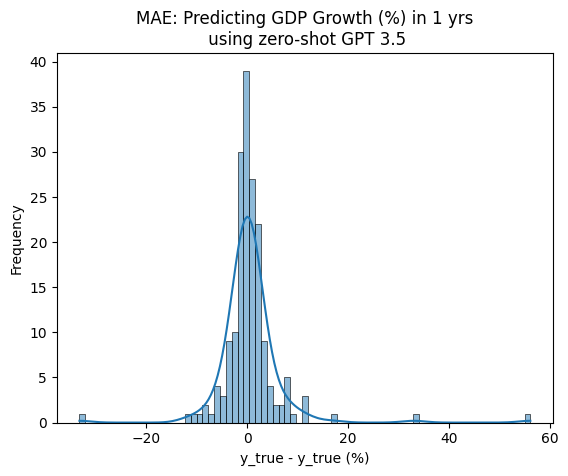

In [45]:
zero_shot_results_df['error'] = zero_shot_results_df['observed_gdp'] - zero_shot_results_df['predicted_gdp']
zero_shot_results_df['abs_error'] = np.abs(zero_shot_results_df['error'])
sns.histplot(zero_shot_results_df['error'], kde=True)
plt.xlabel('y_true - y_true (%)')
plt.ylabel('Frequency')
plt.title('MAE: Predicting GDP Growth (%) in ' + str(PREDICTION_HORIZON) + ' yrs\n using zero-shot GPT 3.5')
plt.show()

#### MAPE

In [46]:
zeroshot_mape = error_mape(zero_shot_results_df['predicted_gdp'],
                           zero_shot_results_df['observed_gdp'])
print('Zero-shot MAPE = ', zeroshot_mape)

Zero-shot MAPE =  1.113613193948607


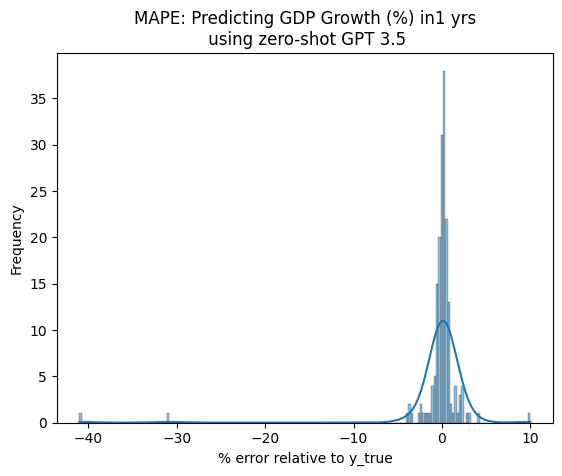

In [47]:
zero_shot_results_df['relative_error'] = (zero_shot_results_df['observed_gdp'] - zero_shot_results_df['predicted_gdp'])/zero_shot_results_df['observed_gdp']
sns.histplot(zero_shot_results_df['relative_error'], kde=True)
plt.xlabel('% error relative to y_true')
plt.ylabel('Frequency')
plt.title('MAPE: Predicting GDP Growth (%) in' + str(PREDICTION_HORIZON) + ' yrs\n using zero-shot GPT 3.5')
plt.show()

#### Write raw results

In [48]:
temp = zero_shot_results_df
temp.head()

,country,predicted_gdp,observed_gdp,error,abs_error,relative_error
0,Albania,6.1,4.8,-1.3,1.3,-0.270833
1,Algeria,4.3,3.2,-1.1,1.1,-0.343750
2,Angola,4.5,3.0,-1.5,1.5,-0.500000
3,Antigua and Barbuda,5.2,8.5,3.3,3.3,0.388235
4,Argentina,2.5,5.0,2.5,2.5,0.500000


In [49]:
temp.columns = ["country", "zeroshot_predicted_gdp", "observed_gdp",
                "zeroshot_error", "zeroshot_abs_error", "zeroshot_relative_error"]
temp.to_csv(now_folder + '/' + 'zeroshot_results_df.csv')
temp.head()

,country,zeroshot_predicted_gdp,observed_gdp,zeroshot_error,zeroshot_abs_error,zeroshot_relative_error
0,Albania,6.1,4.8,-1.3,1.3,-0.270833
1,Algeria,4.3,3.2,-1.1,1.1,-0.343750
2,Angola,4.5,3.0,-1.5,1.5,-0.500000
3,Antigua and Barbuda,5.2,8.5,3.3,3.3,0.388235
4,Argentina,2.5,5.0,2.5,2.5,0.500000


#### Further analysis

In [32]:
finetuned_results_df.nlargest(20, 'abs_error')

,country,predicted_gdp,observed_gdp,error,abs_error,relative_error
68,Guyana,4.8,62.3,57.5,57.5,0.922953
169,Ukraine,5.0,-29.1,-34.1,34.1,1.171821
55,Fiji,-0.2,20.0,20.2,20.2,1.010000
152,Sri Lanka,4.8,-7.8,-12.6,12.6,1.615385
112,Myanmar,-9.2,2.0,11.2,11.2,5.600000
108,Moldova,6.1,-5.0,-11.1,11.1,2.220000
94,Libya,1.1,-9.6,-10.7,10.7,1.114583
139,Samoa,4.8,-5.3,-10.1,10.1,1.905660
137,Saint Lucia,5.9,15.7,9.8,9.8,0.624204
50,El Salvador,12.2,2.6,-9.6,9.6,-3.692308


In [34]:
finetuned_results_df.nlargest(20, 'relative_error')

,country,predicted_gdp,observed_gdp,error,abs_error,relative_error
52,Estonia,6.0,-0.5,-6.5,6.5,13.000000
112,Myanmar,-9.2,2.0,11.2,11.2,5.600000
134,Russian Federation,3.1,-2.1,-5.2,5.2,2.476190
23,Brunei Darussalam,2.0,-1.6,-3.6,3.6,2.250000
108,Moldova,6.1,-5.0,-11.1,11.1,2.220000
71,Hong Kong SAR,3.9,-3.5,-7.4,7.4,2.114286
153,Sudan,2.7,-2.5,-5.2,5.2,2.080000
139,Samoa,4.8,-5.3,-10.1,10.1,1.905660
14,Belarus,3.2,-3.7,-6.9,6.9,1.864865
149,Solomon Islands,2.6,-4.1,-6.7,6.7,1.634146


### Using finetuned results

In [ ]:
finetuned_results_df.head()

,country,predicted_gdp,observed_gdp
0,Albania,7.4,4.8
1,Algeria,3.6,3.2
2,Angola,4.1,3.0
3,Antigua and Barbuda,3.0,8.5
4,Argentina,3.3,5.0


#### MAE

In [ ]:
finetuned_mae = error_mae(finetuned_results_df['predicted_gdp'],
                          finetuned_results_df['observed_gdp'])
print('Finetuned MAE = ', finetuned_mae)

Finetuned MAE =  3.424861878453039


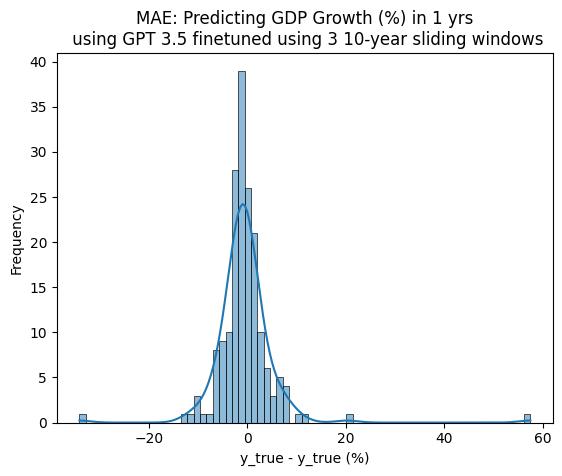

In [ ]:
finetuned_results_df['error'] = finetuned_results_df['observed_gdp'] - finetuned_results_df['predicted_gdp']
finetuned_results_df['abs_error'] = np.abs(finetuned_results_df['error'])
sns.histplot(finetuned_results_df['error'], kde=True)
plt.xlabel('y_true - y_true (%)')
plt.ylabel('Frequency')
plt.title('MAE: Predicting GDP Growth (%) in ' + str(PREDICTION_HORIZON) + ' yrs\n using GPT 3.5 finetuned using 3 10-year sliding windows')
plt.show()

#### MAPE

In [ ]:
finetuned_mape = error_mape(finetuned_results_df['predicted_gdp'],
                            finetuned_results_df['observed_gdp'])
print('Finetuned MAPE = ', finetuned_mape)

Finetuned MAPE =  1.3333265683780744


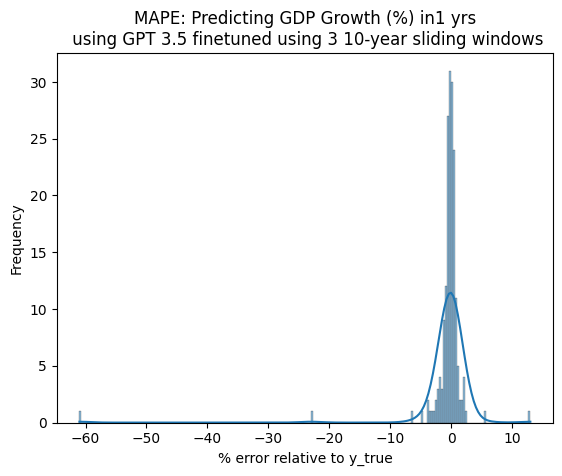

In [ ]:
finetuned_results_df['relative_error'] = (finetuned_results_df['observed_gdp'] - finetuned_results_df['predicted_gdp'])/finetuned_results_df['observed_gdp']
sns.histplot(finetuned_results_df['relative_error'], kde=True)
plt.xlabel('% error relative to y_true')
plt.ylabel('Frequency')
plt.title('MAPE: Predicting GDP Growth (%) in' + str(PREDICTION_HORIZON) + ' yrs\n using GPT 3.5 finetuned using 3 10-year sliding windows')
plt.show()

#### Write raw results

In [ ]:
temp = finetuned_results_df
temp.head()

,country,predicted_gdp,observed_gdp,error,abs_error,relative_error
0,Albania,7.4,4.8,-2.6,2.6,-0.541667
1,Algeria,3.6,3.2,-0.4,0.4,-0.125000
2,Angola,4.1,3.0,-1.1,1.1,-0.366667
3,Antigua and Barbuda,3.0,8.5,5.5,5.5,0.647059
4,Argentina,3.3,5.0,1.7,1.7,0.340000


In [ ]:
temp.columns = ["country", "finetuned_predicted_gdp", "observed_gdp",
                "finetuned_error", "finetuned_abs_error", "finetuned_relative_error"]
temp.to_csv(now_folder + '/' + 'finetuned_results_df.csv')
temp.head()

,country,finetuned_predicted_gdp,observed_gdp,finetuned_error,finetuned_abs_error,finetuned_relative_error
0,Albania,7.4,4.8,-2.6,2.6,-0.541667
1,Algeria,3.6,3.2,-0.4,0.4,-0.125000
2,Angola,4.1,3.0,-1.1,1.1,-0.366667
3,Antigua and Barbuda,3.0,8.5,5.5,5.5,0.647059
4,Argentina,3.3,5.0,1.7,1.7,0.340000


#### Further analysis

In [ ]:
finetuned_results_df.nlargest(20, 'abs_error')

,country,predicted_gdp,observed_gdp,error,abs_error,relative_error
68,Guyana,4.8,62.3,57.5,57.5,0.922953
169,Ukraine,5.0,-29.1,-34.1,34.1,1.171821
55,Fiji,-0.2,20.0,20.2,20.2,1.010000
152,Sri Lanka,4.8,-7.8,-12.6,12.6,1.615385
112,Myanmar,-9.2,2.0,11.2,11.2,5.600000
108,Moldova,6.1,-5.0,-11.1,11.1,2.220000
94,Libya,1.1,-9.6,-10.7,10.7,1.114583
139,Samoa,4.8,-5.3,-10.1,10.1,1.905660
137,Saint Lucia,5.9,15.7,9.8,9.8,0.624204
50,El Salvador,12.2,2.6,-9.6,9.6,-3.692308


In [ ]:
finetuned_results_df.nlargest(20, 'relative_error')

,country,predicted_gdp,observed_gdp,error,abs_error,relative_error
52,Estonia,6.0,-0.5,-6.5,6.5,13.000000
112,Myanmar,-9.2,2.0,11.2,11.2,5.600000
134,Russian Federation,3.1,-2.1,-5.2,5.2,2.476190
23,Brunei Darussalam,2.0,-1.6,-3.6,3.6,2.250000
108,Moldova,6.1,-5.0,-11.1,11.1,2.220000
71,Hong Kong SAR,3.9,-3.5,-7.4,7.4,2.114286
153,Sudan,2.7,-2.5,-5.2,5.2,2.080000
139,Samoa,4.8,-5.3,-10.1,10.1,1.905660
14,Belarus,3.2,-3.7,-6.9,6.9,1.864865
149,Solomon Islands,2.6,-4.1,-6.7,6.7,1.634146


### Using Previous Step

In [144]:
T_MINUS_1 = '2021'

In [145]:
t1_baseline_gdp_growth_df = rounded_gdp_growth_df[['country', T_MINUS_1, str(PREDICTION_YEAR)]]
t1_baseline_gdp_growth_df.head()

,country,2021,2022
0,Albania,8.9,4.8
1,Algeria,3.4,3.2
2,Angola,1.2,3.0
3,Antigua and Barbuda,6.6,8.5
4,Argentina,10.7,5.0


#### MAE

In [146]:
t_minus_1_mae = error_mae(t1_baseline_gdp_growth_df[T_MINUS_1], t1_baseline_gdp_growth_df[PREDICTION_YEAR])
print('T minus ' + str(PREDICTION_HORIZON) + ' MAE = ', t_minus_1_mae)

T minus 1 MAE =  4.299447513812155


<ipython-input-147-65f6a8b27212>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1_baseline_gdp_growth_df['error'] = t1_baseline_gdp_growth_df[PREDICTION_YEAR] - t1_baseline_gdp_growth_df[T_MINUS_1]


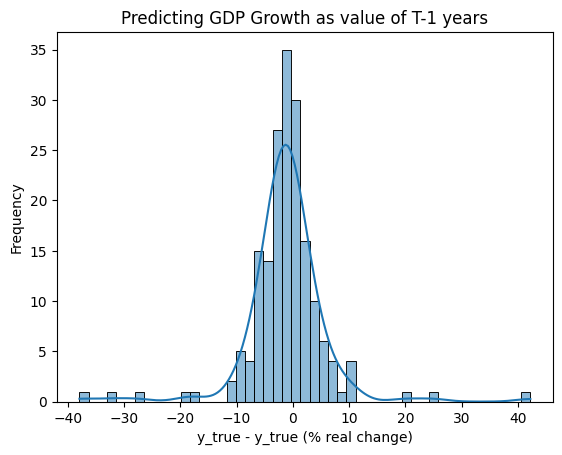

In [147]:
t1_baseline_gdp_growth_df['error'] = t1_baseline_gdp_growth_df[PREDICTION_YEAR] - t1_baseline_gdp_growth_df[T_MINUS_1]
sns.histplot(t1_baseline_gdp_growth_df['error'], kde=True)
plt.xlabel('y_true - y_true (% real change)')
plt.ylabel('Frequency')
plt.title('Predicting GDP Growth as value of T-' + str(PREDICTION_HORIZON) + ' years')
plt.show()

In [148]:
t1_baseline_gdp_growth_df['abs_error'] = np.abs(t1_baseline_gdp_growth_df['error'])

<ipython-input-148-e4faecec4c43>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1_baseline_gdp_growth_df['abs_error'] = np.abs(t1_baseline_gdp_growth_df['error'])


#### MAPE

In [149]:
t_minus_1_mape = error_mape(t1_baseline_gdp_growth_df[T_MINUS_1], t1_baseline_gdp_growth_df[PREDICTION_YEAR])
print('T minus ' + str(PREDICTION_HORIZON) + ' MAE = ', t_minus_1_mape)

T minus 1 MAE =  1.3901344850013484


<ipython-input-150-15622ccdbeb5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1_baseline_gdp_growth_df['relative_error'] = (t1_baseline_gdp_growth_df[PREDICTION_YEAR] - t1_baseline_gdp_growth_df[T_MINUS_1])/(t1_baseline_gdp_growth_df[PREDICTION_YEAR] + 0.000001)


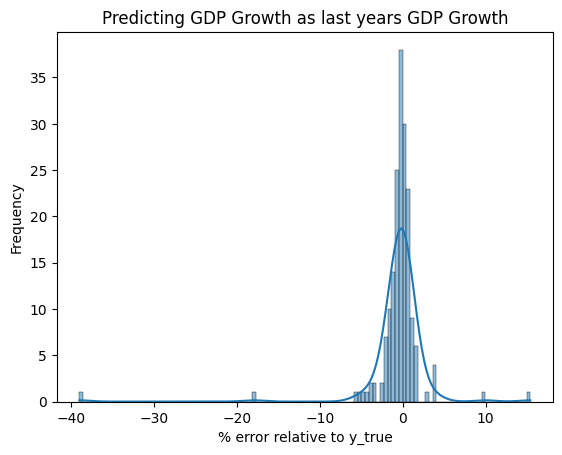

In [150]:
t1_baseline_gdp_growth_df['relative_error'] = (t1_baseline_gdp_growth_df[PREDICTION_YEAR] - t1_baseline_gdp_growth_df[T_MINUS_1])/(t1_baseline_gdp_growth_df[PREDICTION_YEAR] + 0.000001)
sns.histplot(t1_baseline_gdp_growth_df['relative_error'], kde=True)
plt.xlabel('% error relative to y_true')
plt.ylabel('Frequency')
plt.title('Predicting GDP Growth as last years GDP Growth')
plt.show()

In [151]:
t1_baseline_gdp_growth_df[np.abs(t1_baseline_gdp_growth_df['relative_error']) > 10]

,country,2021,2022,error,abs_error,relative_error
52,Estonia,7.2,-0.5,-7.7,7.7,15.400031
126,Paraguay,4.0,0.1,-3.9,3.9,-38.999610
157,São Tomé and Príncipe,1.9,0.1,-1.8,1.8,-17.999820


#### Write raw results

In [152]:
temp = t1_baseline_gdp_growth_df
temp.head()

,country,2021,2022,error,abs_error,relative_error
0,Albania,8.9,4.8,-4.1,4.1,-0.854166
1,Algeria,3.4,3.2,-0.2,0.2,-0.062500
2,Angola,1.2,3.0,1.8,1.8,0.600000
3,Antigua and Barbuda,6.6,8.5,1.9,1.9,0.223529
4,Argentina,10.7,5.0,-5.7,5.7,-1.140000


In [153]:
temp.columns = ["country", "t_minus_1_gdp", "observed_gdp",
                "t_minus_1_error", "t_minus_1_abs_error", "t_minus_1_relative_error"]
temp.to_csv(now_folder + '/' + 't1_baseline_gdp_growth_df.csv')
temp.head()

,country,t_minus_1_gdp,observed_gdp,t_minus_1_error,t_minus_1_abs_error,t_minus_1_relative_error
0,Albania,8.9,4.8,-4.1,4.1,-0.854166
1,Algeria,3.4,3.2,-0.2,0.2,-0.062500
2,Angola,1.2,3.0,1.8,1.8,0.600000
3,Antigua and Barbuda,6.6,8.5,1.9,1.9,0.223529
4,Argentina,10.7,5.0,-5.7,5.7,-1.140000


### Using average growth rates so far


In [171]:
start_year = 2012
end_year = 2021

In [172]:
rounded_gdp_growth_df

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2020,2021,2022,2023,2024,2025,2026,2027,2028,country
0,2.7,5.7,2.9,1.1,2.0,-1.5,5.6,-0.8,-1.4,9.8,...,-3.3,8.9,4.8,3.6,3.3,3.4,3.5,3.5,3.5,Albania
1,-5.4,3.0,6.4,5.4,5.6,5.6,-0.2,-0.7,-1.9,4.8,...,-5.1,3.4,3.2,3.8,3.1,2.5,1.9,1.7,1.7,Algeria
2,2.4,-4.4,0.0,4.2,6.0,3.5,2.9,4.1,6.1,0.0,...,-5.6,1.2,3.0,1.3,3.3,3.4,3.5,3.5,3.6,Angola
3,8.2,3.8,-0.1,5.4,10.2,7.6,11.5,6.6,5.2,5.3,...,-17.5,6.6,8.5,5.6,5.4,4.2,2.8,2.8,2.8,Antigua and Barbuda
4,0.7,-5.7,-3.1,3.7,2.0,-7.0,7.1,2.5,-2.0,-7.0,...,-9.9,10.7,5.0,-2.5,2.8,3.3,3.0,2.8,2.5,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,-3.5,5.8,8.2,7.1,8.4,5.6,3.4,2.5,5.1,7.8,...,2.9,2.6,8.0,4.7,5.8,6.9,6.8,6.8,6.8,Vietnam
178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-11.3,7.0,3.9,3.0,2.7,2.4,2.0,2.0,2.0,West Bank and Gaza
179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-8.5,-1.0,1.5,-0.5,2.0,7.0,6.5,6.0,5.5,Yemen
180,3.9,6.6,-2.9,-1.1,-1.7,1.2,1.7,1.5,9.3,-3.7,...,-2.8,4.6,4.7,3.6,4.3,4.5,4.7,5.0,5.1,Zambia


In [173]:
last_x_years = rounded_gdp_growth_df.loc[:, str(start_year):str(end_year)]

# Calculate the mean along the rows
average_gdp_growth = last_x_years.mean(axis=1)

# Create a new column or Series in your DataFrame with the average GDP values
last_x_years_df = rounded_gdp_growth_df
last_x_years_df['average_growth'] = average_gdp_growth

In [174]:
last_x_years_df.sample(10)

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2021,2022,2023,2024,2025,2026,2027,2028,country,average_growth
144,-2.3,-3.9,-2.1,-0.6,4.3,10.3,0.8,4.9,5.3,10.3,...,2.5,8.9,4.2,3.9,3.9,3.9,3.9,3.6,Seychelles,4.93
51,4.8,5.8,2.2,5.0,1.0,12.9,-2.3,4.4,2.7,-1.2,...,-0.4,3.2,-6.2,-5.5,-4.0,-4.0,-1.7,-0.6,Equatorial Guinea,-3.59
28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.6,3.3,...,3.0,5.2,5.6,6.1,6.4,6.5,6.2,6.3,Cambodia,5.72
39,0.8,-2.3,-7.3,2.9,8.0,0.7,5.5,4.8,3.4,5.7,...,7.8,4.3,4.4,3.2,3.2,3.2,3.2,3.2,Costa Rica,3.15
163,15.8,14.0,12.8,5.8,44.1,5.6,8.8,1.7,-3.5,1.1,...,-2.7,-2.0,2.6,2.5,2.2,1.6,1.2,1.2,Tonga,1.29
175,5.5,4.4,2.0,3.0,9.6,1.0,-0.1,-2.9,-1.7,1.5,...,0.6,1.9,1.5,2.6,3.5,3.1,2.9,2.5,Vanuatu,1.77
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.1,18.6,12.1,...,27.6,10.5,2.3,1.2,1.2,1.1,1.1,1.1,Aruba,1.55
59,0.7,-9.5,20.8,13.5,-7.6,3.6,2.4,2.8,1.7,4.3,...,5.3,4.9,5.6,6.2,5.8,5.0,5.0,5.0,"Gambia, The",3.68
14,NaN,NaN,4.0,4.3,3.0,1.7,3.6,2.8,5.3,3.0,...,2.3,-3.7,1.6,1.3,0.6,0.7,0.9,0.6,Belarus,0.66
11,7.5,2.8,6.4,7.0,4.2,-0.9,0.5,-1.2,6.0,1.0,...,2.6,4.9,2.7,3.6,3.2,2.7,2.7,2.7,Bahrain,2.62


In [175]:
last_x_years_df[last_x_years_df['country']=='India']

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2021,2022,2023,2024,2025,2026,2027,2028,country,average_growth
74,5.3,6.0,3.5,7.3,3.8,5.3,4.8,4.0,9.6,5.9,...,9.1,7.2,6.3,6.3,6.3,6.3,6.3,6.3,India,5.61


#### MAE

In [176]:
last_x_average_mae = error_mae(last_x_years_df['average_growth'], last_x_years_df[PREDICTION_YEAR])
print('Last X average MAE = ', last_x_average_mae)

Last X average MAE =  3.4760773480662976


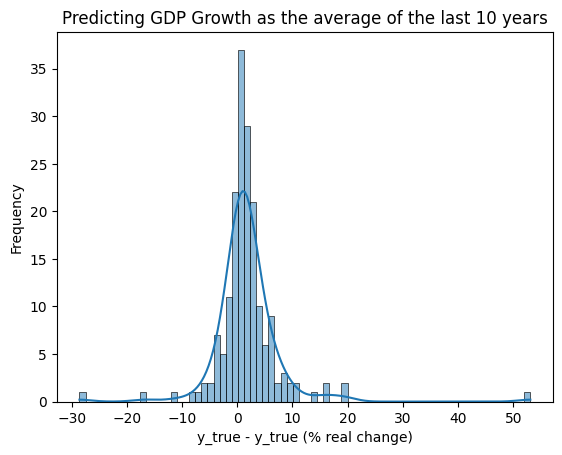

In [177]:
last_x_years_df['error'] = last_x_years_df[PREDICTION_YEAR] - last_x_years_df['average_growth']
sns.histplot(last_x_years_df['error'], kde=True)
plt.xlabel('y_true - y_true (% real change)')
plt.ylabel('Frequency')
plt.title('Predicting GDP Growth as the average of the last 10 years')
plt.show()

In [178]:
last_x_years_df['abs_error'] = np.abs(last_x_years_df['error'])

#### MAPE

In [179]:
last_x_average_mape = error_mape(last_x_years_df['average_growth'], last_x_years_df[PREDICTION_YEAR])
print('Last X average MAPE = ', last_x_average_mape)

Last X average MAPE =  1.0236957431691505


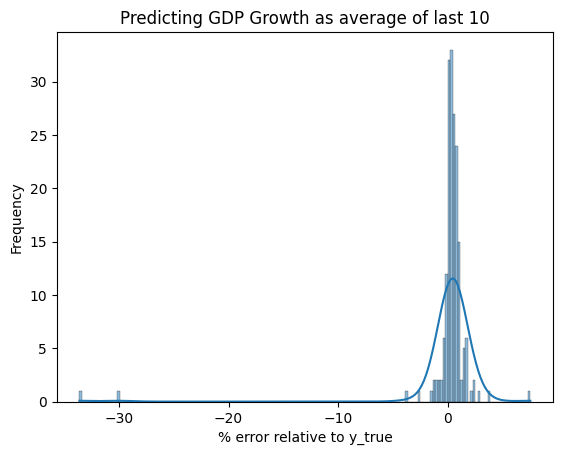

In [180]:
last_x_years_df['relative_error'] = (last_x_years_df[PREDICTION_YEAR] - last_x_years_df['average_growth'])/(last_x_years_df[PREDICTION_YEAR] + 0.000001)
sns.histplot(last_x_years_df['relative_error'], kde=True)
plt.xlabel('% error relative to y_true')
plt.ylabel('Frequency')
plt.title('Predicting GDP Growth as average of last 10')
plt.show()

#### Write raw results

In [182]:
temp = last_x_years_df[["country", "average_growth", "2022", "error", "abs_error", "relative_error"]]
temp.head()

,country,average_growth,2022,error,abs_error,relative_error
0,Albania,2.52,4.8,2.28,2.28,0.475000
1,Algeria,1.88,3.2,1.32,1.32,0.412500
2,Angola,1.00,3.0,2.00,2.00,0.666666
3,Antigua and Barbuda,1.92,8.5,6.58,6.58,0.774118
4,Argentina,-0.15,5.0,5.15,5.15,1.030000


In [183]:
temp.columns = ["country", "avg_growth_10y_prediction", "observed_gdp",
                "avg_growth_10y_error", "avg_growth_10y_error", "avg_growth_10y_relative_error"]
temp.to_csv(now_folder + '/' + 'avg_growth_10y_df.csv')
temp.head()

,country,avg_growth_10y_prediction,observed_gdp,avg_growth_10y_error,avg_growth_10y_error,avg_growth_10y_relative_error
0,Albania,2.52,4.8,2.28,2.28,0.475000
1,Algeria,1.88,3.2,1.32,1.32,0.412500
2,Angola,1.00,3.0,2.00,2.00,0.666666
3,Antigua and Barbuda,1.92,8.5,6.58,6.58,0.774118
4,Argentina,-0.15,5.0,5.15,5.15,1.030000


### Using xgboost

In [35]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

In [46]:
xgb_start_year = 2001
xgb_end_year = 2022
last_x_years = rounded_gdp_growth_df.loc[:, str(xgb_start_year):str(xgb_end_year)]
last_x_years.head()

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,8.3,4.5,5.5,5.5,5.5,5.9,6.0,7.5,3.4,3.7,...,1.0,1.8,2.2,3.3,3.8,4.0,2.1,-3.3,8.9,4.8
1,3.0,5.6,7.2,4.3,5.9,1.7,3.4,2.4,1.6,3.6,...,2.8,3.8,3.7,3.2,1.4,1.2,1.0,-5.1,3.4,3.2
2,4.2,13.7,3.0,11.0,15.0,11.5,14.0,11.2,0.9,4.9,...,5.0,4.8,0.9,-2.6,-0.2,-1.3,-0.7,-5.6,1.2,3.0
3,-4.5,1.0,6.1,5.8,6.5,12.7,9.3,0.0,-12.0,-7.8,...,-0.6,3.8,3.8,5.5,3.1,6.8,4.3,-17.5,6.6,8.5
4,-4.4,-10.9,9.0,8.9,8.9,8.0,9.0,4.1,-5.9,10.1,...,2.4,-2.5,2.7,-2.1,2.8,-2.6,-2.0,-9.9,10.7,5.0


In [56]:
data = rounded_gdp_growth_df

# Assuming the 'Country' column is the index
data.set_index('country', inplace=True)

data = data.loc[:, str(xgb_start_year):str(xgb_end_year)]
data.head()

# # Extract features (X) and target variable (y)
# X = data.drop('2022', axis=1)  # Features from 2001 to 2021
# y = data['2022']  # Target variable for prediction

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X.drop('2022', axis=1),
#                                                     data['2021'],y, test_size=0.2, random_state=42)

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
country,,,,,,,,,,,,,,,,,,,,,
Albania,8.3,4.5,5.5,5.5,5.5,5.9,6.0,7.5,3.4,3.7,...,1.0,1.8,2.2,3.3,3.8,4.0,2.1,-3.3,8.9,4.8
Algeria,3.0,5.6,7.2,4.3,5.9,1.7,3.4,2.4,1.6,3.6,...,2.8,3.8,3.7,3.2,1.4,1.2,1.0,-5.1,3.4,3.2
Angola,4.2,13.7,3.0,11.0,15.0,11.5,14.0,11.2,0.9,4.9,...,5.0,4.8,0.9,-2.6,-0.2,-1.3,-0.7,-5.6,1.2,3.0
Antigua and Barbuda,-4.5,1.0,6.1,5.8,6.5,12.7,9.3,0.0,-12.0,-7.8,...,-0.6,3.8,3.8,5.5,3.1,6.8,4.3,-17.5,6.6,8.5
Argentina,-4.4,-10.9,9.0,8.9,8.9,8.0,9.0,4.1,-5.9,10.1,...,2.4,-2.5,2.7,-2.1,2.8,-2.6,-2.0,-9.9,10.7,5.0


In [57]:
X_train = data.loc[:, str(xgb_start_year):str(xgb_end_year-2)]
y_train = data.loc[:, str(xgb_end_year-1)]
X_test = data.loc[:, str(xgb_start_year+1):str(xgb_end_year-1)]
y_test = data.loc[:, str(xgb_end_year)]

In [58]:
X_train.head()

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
country,,,,,,,,,,,,,,,,,,,,
Albania,8.3,4.5,5.5,5.5,5.5,5.9,6.0,7.5,3.4,3.7,2.5,1.4,1.0,1.8,2.2,3.3,3.8,4.0,2.1,-3.3
Algeria,3.0,5.6,7.2,4.3,5.9,1.7,3.4,2.4,1.6,3.6,2.9,3.4,2.8,3.8,3.7,3.2,1.4,1.2,1.0,-5.1
Angola,4.2,13.7,3.0,11.0,15.0,11.5,14.0,11.2,0.9,4.9,3.5,8.5,5.0,4.8,0.9,-2.6,-0.2,-1.3,-0.7,-5.6
Antigua and Barbuda,-4.5,1.0,6.1,5.8,6.5,12.7,9.3,0.0,-12.0,-7.8,-2.0,3.4,-0.6,3.8,3.8,5.5,3.1,6.8,4.3,-17.5
Argentina,-4.4,-10.9,9.0,8.9,8.9,8.0,9.0,4.1,-5.9,10.1,6.0,-1.0,2.4,-2.5,2.7,-2.1,2.8,-2.6,-2.0,-9.9


In [59]:
y_train.head()

country
Albania                 8.9
Algeria                 3.4
Angola                  1.2
Antigua and Barbuda     6.6
Argentina              10.7
Name: 2021, dtype: float64

In [60]:
X_test.head()

,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
country,,,,,,,,,,,,,,,,,,,,
Albania,4.5,5.5,5.5,5.5,5.9,6.0,7.5,3.4,3.7,2.5,1.4,1.0,1.8,2.2,3.3,3.8,4.0,2.1,-3.3,8.9
Algeria,5.6,7.2,4.3,5.9,1.7,3.4,2.4,1.6,3.6,2.9,3.4,2.8,3.8,3.7,3.2,1.4,1.2,1.0,-5.1,3.4
Angola,13.7,3.0,11.0,15.0,11.5,14.0,11.2,0.9,4.9,3.5,8.5,5.0,4.8,0.9,-2.6,-0.2,-1.3,-0.7,-5.6,1.2
Antigua and Barbuda,1.0,6.1,5.8,6.5,12.7,9.3,0.0,-12.0,-7.8,-2.0,3.4,-0.6,3.8,3.8,5.5,3.1,6.8,4.3,-17.5,6.6
Argentina,-10.9,9.0,8.9,8.9,8.0,9.0,4.1,-5.9,10.1,6.0,-1.0,2.4,-2.5,2.7,-2.1,2.8,-2.6,-2.0,-9.9,10.7


In [61]:
y_test.head()

country
Albania                4.8
Algeria                3.2
Angola                 3.0
Antigua and Barbuda    8.5
Argentina              5.0
Name: 2022, dtype: float64

In [68]:
# Create an XGBoost regressor
xgb_model = XGBRegressor()

# rename columns to make them match
x_col = [str(i+1) for i in np.arange(20)]
print(x_col)
X_train.columns = x_col
X_test.columns = x_col

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']


In [69]:
# Train the model on the training set
xgb_model.fit(X_train, y_train)

# Make predictions on the test set (2022)
xgb_predictions = xgb_model.predict(X_test)

In [73]:
list(xgb_predictions)[0:10]

[14.247793,
 3.7744305,
 -0.5678999,
 7.9964404,
 8.394354,
 3.6617057,
 5.9400067,
 4.8008904,
 3.841447,
 0.29972857]

In [78]:
# Add the predicted values to the original DataFrame
data['xgboost_2022'] = xgb_predictions
xgb_df = data
xgb_df.to_csv('xgboost_predictions_gdp_growth_1y.csv')

#### MAE

In [75]:
xgboost_mae = error_mae(list(xgb_predictions), y_test)
print('xgboost average MAE = ', xgboost_mae)

xgboost average MAE =  4.832673918126532


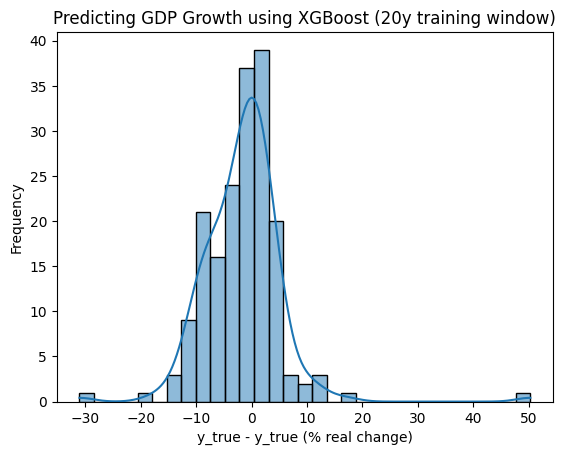

In [79]:
xgb_df['error'] = xgb_df[PREDICTION_YEAR] - xgb_df['xgboost_2022']
sns.histplot(xgb_df['error'], kde=True)
plt.xlabel('y_true - y_true (% real change)')
plt.ylabel('Frequency')
plt.title('Predicting GDP Growth using XGBoost (20y training window)')
plt.show()

#### MAPE

In [76]:
xgboost_mape = error_mape(list(xgb_predictions), y_test)
print('xgboost average MAPE = ', xgboost_mape)

xgboost average MAPE =  1.8399706667658944


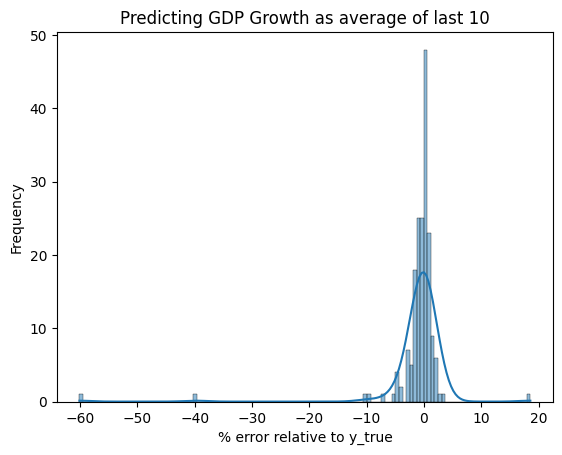

In [80]:
xgb_df['relative_error'] = (xgb_df[PREDICTION_YEAR] - xgb_df['xgboost_2022'])/(xgb_df[PREDICTION_YEAR] + 0.000001)
sns.histplot(xgb_df['relative_error'], kde=True)
plt.xlabel('% error relative to y_true')
plt.ylabel('Frequency')
plt.title('Predicting GDP Growth as average of last 10')
plt.show()

In [81]:
xgb_df.to_csv('xgboost_predictions_gdp_growth_1y.csv')

### Expert Forecasts - IMF Oct 2021 Predictions

In [187]:
imf_df = pd.read_csv('imf_growth_forecasts_oct_2021.csv')
imf_df.head(5)

,Country,Subject Descriptor,Units,Scale,Country/Series-specific Notes,2018,2019,2020,2021,2022,2023,2024,2025,Estimates Start After
0,Afghanistan,"Gross domestic product, constant prices",Percent change,NaN,"See notes for: Gross domestic product, consta...",1.189,3.912,-2.351,NaN,NaN,NaN,NaN,NaN,2019.0
1,Albania,"Gross domestic product, constant prices",Percent change,NaN,"See notes for: Gross domestic product, consta...",4.071,2.174,-3.311,5.300,4.500,4.100,3.700,3.486,2020.0
2,Algeria,"Gross domestic product, constant prices",Percent change,NaN,"See notes for: Gross domestic product, consta...",1.200,0.800,-4.900,3.410,1.947,1.706,0.814,0.122,2019.0
3,Andorra,"Gross domestic product, constant prices",Percent change,NaN,"See notes for: Gross domestic product, consta...",1.589,2.017,-11.969,5.500,4.800,2.700,2.222,1.540,2020.0
4,Angola,"Gross domestic product, constant prices",Percent change,NaN,"See notes for: Gross domestic product, consta...",-2.045,-0.535,-5.385,-0.655,2.364,3.328,3.657,3.812,2020.0


In [188]:
cleaned_imf_df = imf_df[~imf_df['2022'].isnull()]
cleaned_imf_df = cleaned_imf_df[["Country", "2022"]]
cleaned_imf_df.columns = ['country', 'imf_2022_forecast']
print(cleaned_imf_df.shape)
cleaned_imf_df.head()

(192, 2)


,country,imf_2022_forecast
1,Albania,4.500
2,Algeria,1.947
3,Andorra,4.800
4,Angola,2.364
5,Antigua and Barbuda,7.019


In [189]:
print(cleaned_imf_df.shape)
imf_results_df = pd.merge(rounded_gdp_growth_df.reset_index()[["country", "2022"]],
                          cleaned_imf_df, how="inner", on="country")
print(imf_results_df.shape)
imf_results_df.head()

(192, 2)
(164, 3)


,country,2022,imf_2022_forecast
0,Albania,4.8,4.500
1,Algeria,3.2,1.947
2,Angola,3.0,2.364
3,Antigua and Barbuda,8.5,7.019
4,Argentina,5.0,2.465


#### MAE

In [190]:
imf_mae = error_mae(imf_results_df['imf_2022_forecast'],
                    imf_results_df['2022'])
print('IMF MAE = ', imf_mae)

IMF MAE =  2.5792256097560977


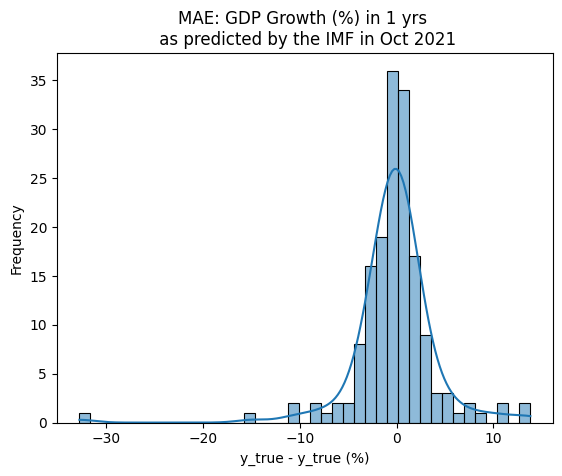

In [191]:
imf_results_df['error'] = imf_results_df['2022'] - imf_results_df['imf_2022_forecast']
imf_results_df['abs_error'] = np.abs(imf_results_df['error'])
sns.histplot(imf_results_df['error'], kde=True)
plt.xlabel('y_true - y_true (%)')
plt.ylabel('Frequency')
plt.title('MAE: GDP Growth (%) in ' + str(PREDICTION_HORIZON) + ' yrs \n as predicted by the IMF in Oct 2021')
plt.show()

#### MAPE

In [192]:
imf_mape = error_mape(imf_results_df['imf_2022_forecast'],
                      imf_results_df['2022'])
print('IMF MAPE = ', imf_mape)

IMF MAPE =  0.8955265764057417


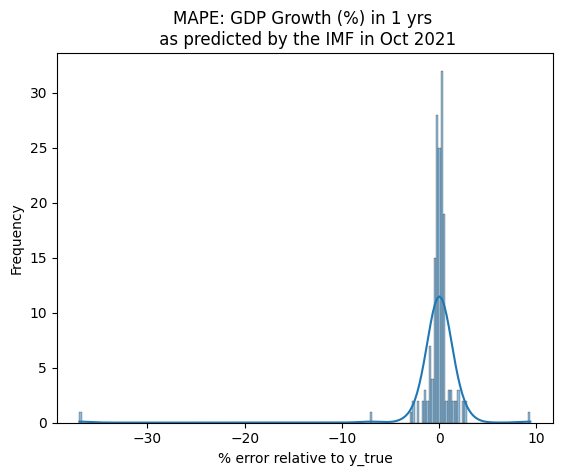

In [193]:
imf_results_df['relative_error'] = (imf_results_df['2022'] - imf_results_df['imf_2022_forecast'])/imf_results_df['2022']
imf_results_df['abs_error'] = np.abs(imf_results_df['error'])
sns.histplot(imf_results_df['relative_error'], kde=True)
plt.xlabel('% error relative to y_true')
plt.ylabel('Frequency')
plt.title('MAPE: GDP Growth (%) in ' + str(PREDICTION_HORIZON) + ' yrs \n as predicted by the IMF in Oct 2021')
plt.show()

In [194]:
imf_results_df.head()

,country,2022,imf_2022_forecast,error,abs_error,relative_error
0,Albania,4.8,4.500,0.300,0.300,0.062500
1,Algeria,3.2,1.947,1.253,1.253,0.391563
2,Angola,3.0,2.364,0.636,0.636,0.212000
3,Antigua and Barbuda,8.5,7.019,1.481,1.481,0.174235
4,Argentina,5.0,2.465,2.535,2.535,0.507000


In [195]:
imf_results_df.to_csv(now_folder + '/' + 'imf_results.csv')

In [99]:
imf_results_df.nlargest(20, 'abs_error')

,country,2022,imf_2022_forecast,error,abs_error,relative_error
151,Ukraine,-29.1,3.636,-32.736,32.736,1.124948
84,Libya,-9.6,5.252,-14.852,14.852,1.547083
49,Fiji,20.0,6.195,13.805,13.805,0.690250
61,Guyana,62.3,48.709,13.591,13.591,0.218154
136,Sri Lanka,-7.8,3.296,-11.096,11.096,1.422564
158,Venezuela,8.0,-3.000,11.000,11.000,1.375000
26,Cabo Verde,17.0,6.504,10.496,10.496,0.617412
97,Moldova,-5.0,5.172,-10.172,10.172,2.034400
46,Equatorial Guinea,3.2,-5.626,8.826,8.826,2.758125
133,Solomon Islands,-4.1,4.395,-8.495,8.495,2.071951


## Further Analysis

In [ ]:
last_x_years_df.head()
last_x_years_df['avg_x_years_average_growth'] = last_x_years_df['average_growth']
last_x_years_df['avg_x_years_error'] = last_x_years_df['error']
last_x_years_df['avg_x_years_relative_error'] = last_x_years_df['relative_error']
# finetuned_results_df.head()

In [ ]:
analysis_df = pd.merge(finetuned_results_df,
                       last_x_years_df[['country', 'avg_x_years_average_growth',
                                        'avg_x_years_error', 'avg_x_years_relative_error']],
                       on = 'country')
analysis_df

,Unnamed: 0,country,predicted_gdp,observed_gdp,error,abs_error,relative_error,avg_x_years_average_growth,avg_x_years_error,avg_x_years_relative_error
0,0,Albania,7.2,4.8,-2.4,2.4,-0.500000,2.52,2.28,0.475000
1,1,Algeria,3.3,3.2,-0.1,0.1,-0.031250,1.88,1.32,0.412500
2,2,Angola,2.1,3.0,0.9,0.9,0.300000,1.00,2.00,0.666666
3,3,Antigua and Barbuda,4.1,8.5,4.4,4.4,0.517647,1.92,6.58,0.774118
4,4,Argentina,4.4,5.0,0.6,0.6,0.120000,-0.15,5.15,1.030000
...,...,...,...,...,...,...,...,...,...,...
176,177,Vietnam,6.3,8.0,1.7,1.7,0.212500,5.85,2.15,0.268750
177,178,West Bank and Gaza,4.1,3.9,-0.2,0.2,-0.051282,2.29,1.61,0.412820
178,179,Yemen,0.1,1.5,1.4,1.4,0.933333,-4.21,5.71,3.806664
179,180,Zambia,3.6,4.7,1.1,1.1,0.234043,3.48,1.22,0.259574


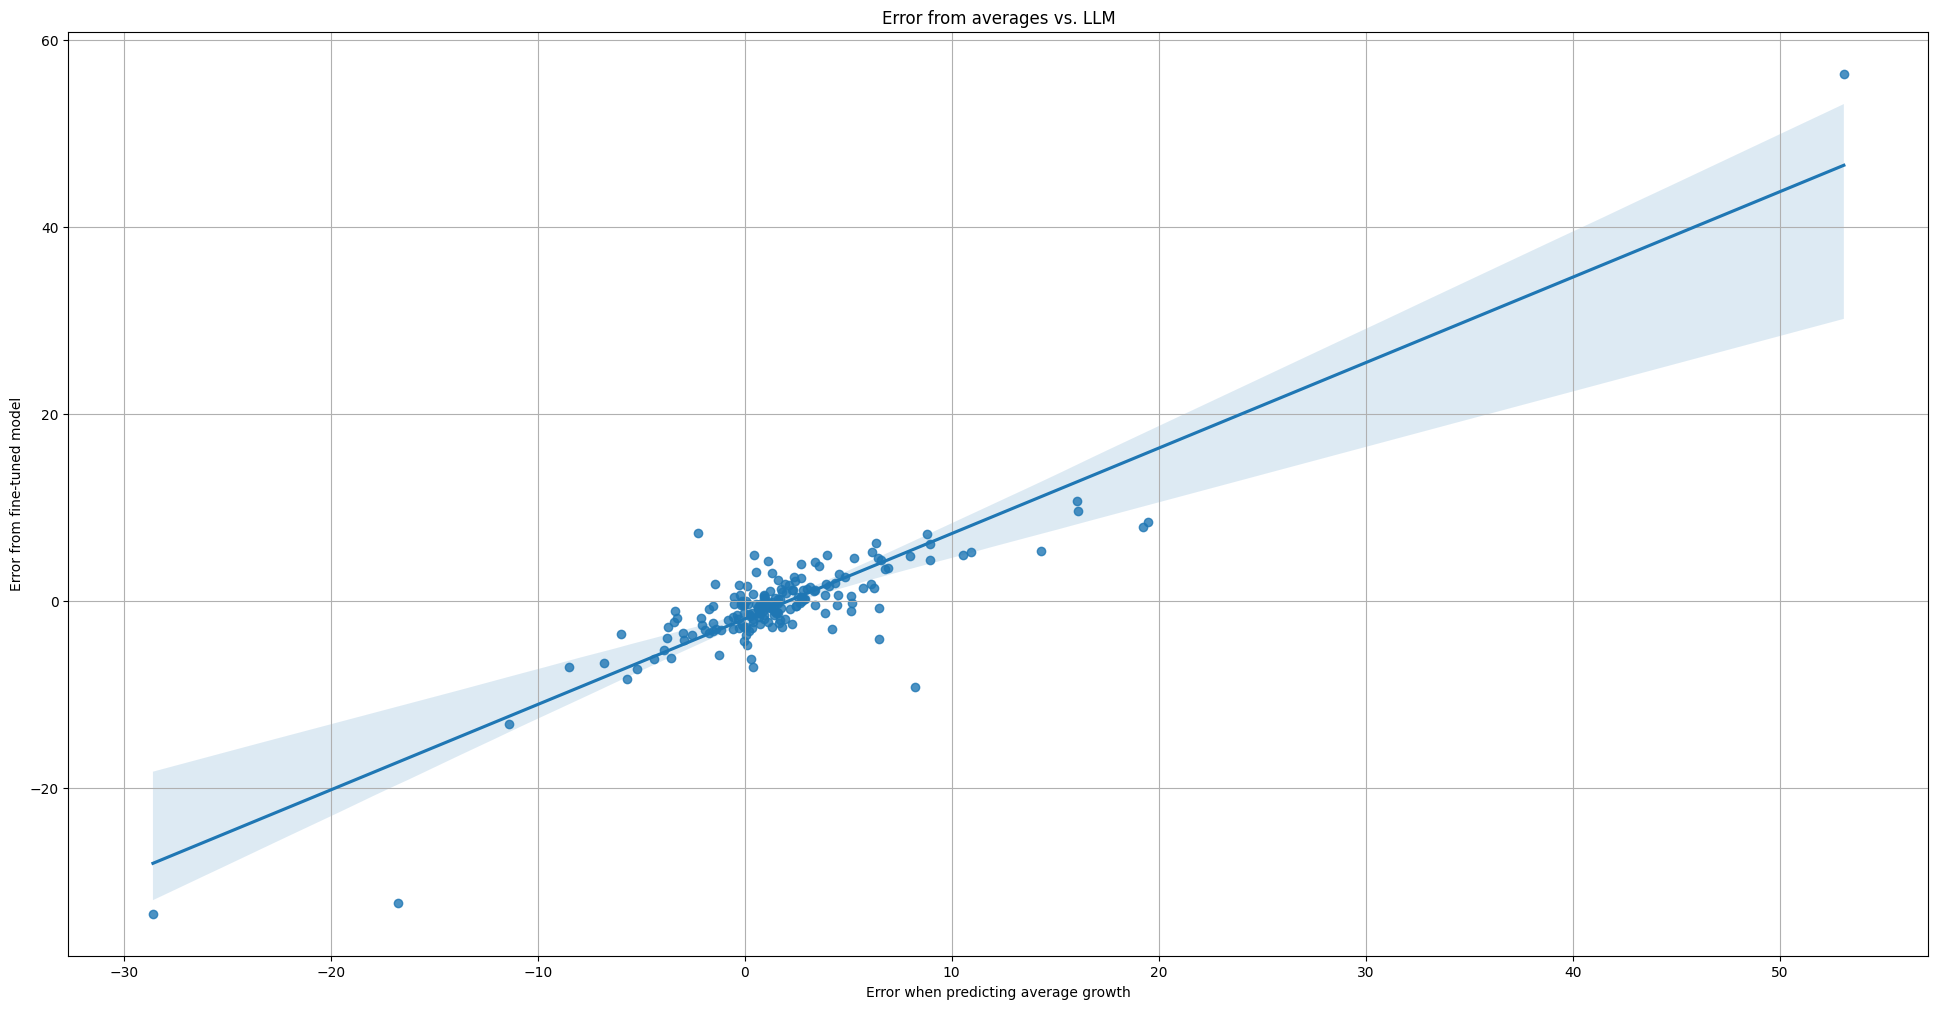

In [ ]:
# Scatter plot using seaborn
plt.figure(figsize=(24, 12))
scatter_plot = sns.regplot(x='avg_x_years_error', y='error', data=analysis_df)
plt.title('Error from averages vs. LLM')
plt.xlabel('Error when predicting average growth')
plt.ylabel('Error from fine-tuned model')
# # Add labels for each point
# for line in range(0, analysis_df.shape[0]):
#   scatter_plot.text(analysis_df['avg_x_years_error'][line] + 0.1,
#                     analysis_df['error'][line],
#                     analysis_df['country'][line],
#                     horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.grid(True)
plt.show()

In [ ]:
# Calculate and print the correlation coefficient
from scipy.stats import pearsonr
correlation_coefficient, _ = pearsonr(analysis_df['avg_x_years_error'], analysis_df['error'])
print(f'Correlation Coefficient: {correlation_coefficient:.2f}')

Correlation Coefficient: 0.89


#### Error in biggest countries

In [ ]:
gdp_df = pd.read_csv("cleaned_gdp_df_countries.csv")
gdp_df.head()

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2020,2021,2022,2023,2024,2025,2026,2027,2028,country
0,1.9,2.2,2.3,2.3,2.3,2.3,2.6,2.6,2.5,2.8,...,15.2,18.0,19.1,23.0,25.3,26.4,27.8,29.5,31.4,Albania
1,42.3,44.4,44.8,47.5,51.5,61.1,61.5,63.3,51.7,52.6,...,145.7,163.1,195.1,224.1,239.2,247.7,255.3,259.3,262.8,Algeria
2,6.6,6.2,6.2,6.5,6.9,8.5,7.9,9.0,9.8,11.4,...,57.1,74.9,122.8,93.8,92.9,96.9,100.8,106.4,111.8,Angola
3,0.1,0.1,0.2,0.2,0.2,0.2,0.3,0.3,0.4,0.4,...,1.4,1.6,1.8,1.9,2.1,2.3,2.4,2.5,2.6,Antigua and Barbuda
4,233.7,189.8,94.2,116.3,130.5,98.6,118.6,121.6,142.4,91.4,...,389.1,487.4,630.6,621.8,632.6,635.9,660.3,695.3,728.1,Argentina


In [ ]:
largest_countries = list(gdp_df.nlargest(50, "2021").country)
largest_countries

['United States',
 "China, People's Republic of",
 'Japan',
 'Germany',
 'India',
 'United Kingdom',
 'France',
 'Italy',
 'Canada',
 'Korea, Republic of',
 'Brazil',
 'Australia',
 'Spain',
 'Mexico',
 'Indonesia',
 'Netherlands',
 'Saudi Arabia',
 'Türkiye, Republic of',
 'Switzerland',
 'Taiwan Province of China',
 'Poland',
 'Sweden',
 'Belgium',
 'Ireland',
 'Thailand',
 'Norway',
 'Israel',
 'Argentina',
 'Austria',
 'Singapore',
 'Egypt',
 'South Africa',
 'Bangladesh',
 'United Arab Emirates',
 'Denmark',
 'Philippines',
 'Malaysia',
 'Vietnam',
 'Hong Kong SAR',
 'Colombia',
 'Chile',
 'Finland',
 'Iran',
 'Romania',
 'Portugal',
 'New Zealand',
 'Peru',
 'Greece',
 'Hungary',
 'Qatar']

In [ ]:
analysis_df50 = analysis_df[analysis_df.country.isin(largest_countries)]
analysis_df50.head()

,Unnamed: 0,country,predicted_gdp,observed_gdp,error,abs_error,relative_error,avg_x_years_average_growth,avg_x_years_error,avg_x_years_relative_error
4,4,Argentina,4.4,5.0,0.6,0.6,0.120000,-0.15,5.15,1.030000
7,7,Australia,4.3,3.7,-0.6,0.6,-0.162162,2.41,1.29,0.348649
8,8,Austria,3.0,4.8,1.8,1.8,0.375000,0.87,3.93,0.818750
12,12,Bangladesh,7.9,7.1,-0.8,0.8,-0.112676,6.44,0.66,0.092958
15,15,Belgium,5.1,3.2,-1.9,1.9,-0.593750,1.27,1.93,0.603125


In [ ]:
finetuned_mae_analysis_df50 = error_mae(analysis_df50['predicted_gdp'],
                                        analysis_df50['observed_gdp'])
print('Finetuned MAE of 50 largest countries = ', finetuned_mae_analysis_df50)

Finetuned MAE of 50 largest countries =  1.71


In [ ]:
finetuned_mape_analysis_df50 = error_mape(analysis_df50['predicted_gdp'],
                                          analysis_df50['observed_gdp'])
print('Finetuned MAPE of 50 largest countries = ', finetuned_mape_analysis_df50)

Finetuned MAPE of 50 largest countries =  0.47530392642889896


<ipython-input-75-834deac7ca49>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df50['relative_error'] = (analysis_df50['observed_gdp'] - analysis_df50['predicted_gdp'])/analysis_df50['observed_gdp']


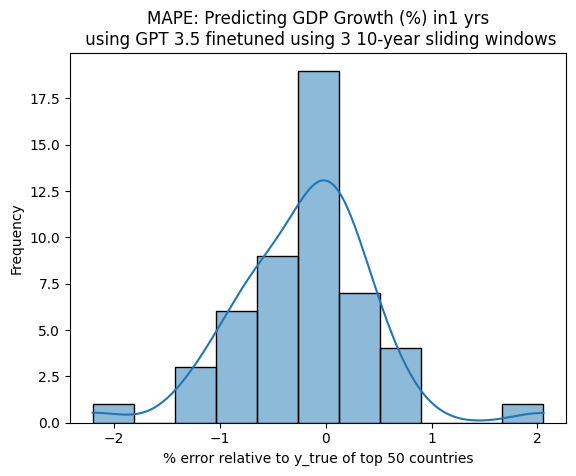

In [ ]:
analysis_df50['relative_error'] = (analysis_df50['observed_gdp'] - analysis_df50['predicted_gdp'])/analysis_df50['observed_gdp']
sns.histplot(analysis_df50['relative_error'], kde=True)
plt.xlabel('% error relative to y_true of top 50 countries')
plt.ylabel('Frequency')
plt.title('MAPE: Predicting GDP Growth (%) in' + str(PREDICTION_HORIZON) + ' yrs\n using GPT 3.5 finetuned using 3 10-year sliding windows')
plt.show()

In [ ]:
np.mean(np.abs(analysis_df50['avg_x_years_error']))

2.2616

In [ ]:
np.mean(np.abs(analysis_df50['avg_x_years_relative_error']))

0.4950707885091954

### Expert predictions

For now:
- IMF (how will we compare the $ amount??)

We should pull in others eventually
- World Bank
- The Economist
- Fitch
- Various central banks

#### Clean IMF Forecast Data from Fall 2021

In [ ]:
raw_2021_imf_forecast = pd.read_csv('imf_economic_outlook_Oct2021all.csv')
print(raw_2021_imf_forecast.shape)
raw_2021_imf_forecast.head()

(8823, 57)


,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,1980,...,2018,2019,2020,2021,2022,2023,2024,2025,2026,Estimates Start After
0,512,AFG,NGDP_R,Afghanistan,"Gross domestic product, constant prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,270.22","1,319.90","1,288.87",NaN,NaN,NaN,NaN,NaN,NaN,2019.0
1,512,AFG,NGDP_RPCH,Afghanistan,"Gross domestic product, constant prices",Annual percentages of constant price GDP are y...,Percent change,NaN,"See notes for: Gross domestic product, consta...",NaN,...,1.189,3.912,-2.351,NaN,NaN,NaN,NaN,NaN,NaN,2019.0
2,512,AFG,NGDP,Afghanistan,"Gross domestic product, current prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,327.69","1,469.60","1,547.29",NaN,NaN,NaN,NaN,NaN,NaN,2019.0
3,512,AFG,NGDPD,Afghanistan,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,18.401,18.876,20.136,NaN,NaN,NaN,NaN,NaN,NaN,2019.0
4,512,AFG,PPPGDP,Afghanistan,"Gross domestic product, current prices",These data form the basis for the country weig...,Purchasing power parity; international dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,77.406,81.873,80.912,NaN,NaN,NaN,NaN,NaN,NaN,2019.0


In [ ]:
imf_2021_forecast = raw_2021_imf_forecast[raw_2021_imf_forecast['Subject Descriptor'] ==
                                          "Gross domestic product, current prices"]
print(imf_2021_forecast.shape[0])
imf_2021_forecast = imf_2021_forecast[imf_2021_forecast['Units'] == "U.S. dollars"]
print(imf_2021_forecast.shape[0])
# imf_2021_forecast = imf_2021_forecast[imf_2021_forecast['Scale'] == "Billions"]
# print(imf_2021_forecast.shape[0])
# imf_2021_forecast = imf_2021_forecast[imf_2021_forecast['Country/Series-specific Notes'].str.contains("IMF")]
# print(imf_2021_forecast.shape[0])
imf_2021_forecast = imf_2021_forecast[imf_2021_forecast.Country.isin(cleaned_gdp_countries.country)]
print(imf_2021_forecast.shape[0])
imf_2021_forecast

588
196
127


,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,1980,...,2018,2019,2020,2021,2022,2023,2024,2025,2026,Estimates Start After
48,914,ALB,NGDPD,Albania,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",1.946,...,15.147,15.283,14.828,16.77,18.012,18.931,20.026,21.15,22.308,2020.0
93,612,DZA,NGDPD,Algeria,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",42.346,...,175.367,171.07,147.6,163.812,168.195,172.094,173.719,174.376,175.228,2019.0
183,614,AGO,NGDPD,Angola,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",6.639,...,101.353,84.516,58.376,70.339,74.953,79.304,84.614,90.888,96.437,2020.0
228,311,ATG,NGDPD,Antigua and Barbuda,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",0.131,...,1.605,1.687,1.37,1.405,1.534,1.652,1.759,1.855,1.943,2019.0
273,213,ARG,NGDPD,Argentina,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",233.696,...,524.431,451.815,389.064,455.172,483.765,476.485,488.269,511.523,536.229,2020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,111,USA,NGDPD,United States,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...","2,857.33",...,"20,527.15","21,372.60","20,893.75","22,939.58","24,796.08","25,938.16","26,980.36","28,035.09","29,102.50",2020.0
8418,298,URY,NGDPD,Uruguay,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",12.165,...,64.766,61.931,56.577,60.108,63.741,65.862,68.59,71.617,74.554,2020.0
8508,846,VUT,NGDPD,Vanuatu,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",0.121,...,0.928,0.928,0.932,0.999,1.06,1.127,1.194,1.253,1.315,2018.0
8598,582,VNM,NGDPD,Vietnam,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",35.357,...,303.091,327.873,343.114,368.002,415.493,461.023,512.99,570.036,630.465,2020.0


In [ ]:
cols = ["Country", "2019", "2020", "2021", "2022", "Units", "Scale", "Subject Descriptor",
        "Country/Series-specific Notes", "ISO", "Estimates Start After"]
imf_2021_forecast_df = imf_2021_forecast[cols]
new_cols = ["country","2019", "2020", "2021", "2022_forecast", "units", "scale", "about", "notes", "iso", "forecasts_after"]
imf_2021_forecast_df.columns = new_cols
imf_2021_forecast_df.head()

,country,2019,2020,2021,2022_forecast,units,scale,about,notes,iso,forecasts_after
48,Albania,15.283,14.828,16.77,18.012,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",ALB,2020.0
93,Algeria,171.07,147.6,163.812,168.195,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",DZA,2019.0
183,Angola,84.516,58.376,70.339,74.953,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",AGO,2020.0
228,Antigua and Barbuda,1.687,1.37,1.405,1.534,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",ATG,2019.0
273,Argentina,451.815,389.064,455.172,483.765,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",ARG,2020.0


In [ ]:
imf_2021_forecast_df[['forecasts_after']].value_counts()

forecasts_after
2020.0             90
2019.0             25
2018.0              6
2017.0              3
2014.0              1
2016.0              1
2021.0              1
dtype: int64

In [ ]:
cleaned_gdp_countries_df[['country']].value_counts().max()

1

In [ ]:
temp = cleaned_gdp_countries_df[["country", "2022"]]
imf_forecast_results_df = pd.merge(imf_2021_forecast_df,
                                   cleaned_gdp_countries_df[["country", "2022"]],
                                   on = "country")
imf_forecast_results_df

,country,2019,2020,2021,2022_forecast,units,scale,about,notes,iso,forecasts_after,2022
0,Albania,15.283,14.828,16.77,18.012,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",ALB,2020.0,19.1
1,Algeria,171.07,147.6,163.812,168.195,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",DZA,2019.0,195.1
2,Angola,84.516,58.376,70.339,74.953,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",AGO,2020.0,122.8
3,Antigua and Barbuda,1.687,1.37,1.405,1.534,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",ATG,2019.0,1.8
4,Argentina,451.815,389.064,455.172,483.765,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",ARG,2020.0,630.6
...,...,...,...,...,...,...,...,...,...,...,...,...
122,United States,"21,372.60","20,893.75","22,939.58","24,796.08",U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",USA,2020.0,25462.7
123,Uruguay,61.931,56.577,60.108,63.741,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",URY,2020.0,71.2
124,Vanuatu,0.928,0.932,0.999,1.06,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",VUT,2018.0,1.1
125,Vietnam,327.873,343.114,368.002,415.493,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",VNM,2020.0,406.5


In [ ]:
imf_forecast_results_df['2022'] = pd.to_numeric(imf_forecast_results_df['2022'], errors='coerce')
imf_forecast_results_df['2022_forecast'] = pd.to_numeric(imf_forecast_results_df['2022_forecast'], errors='coerce')

#### MAE

In [ ]:
imf_forecast_results_df.head()

,country,2019,2020,2021,2022_forecast,units,scale,about,notes,iso,forecasts_after,2022
0,Albania,15.283,14.828,16.77,18.012,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",ALB,2020.0,19.1
1,Algeria,171.07,147.6,163.812,168.195,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",DZA,2019.0,195.1
2,Angola,84.516,58.376,70.339,74.953,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",AGO,2020.0,122.8
3,Antigua and Barbuda,1.687,1.37,1.405,1.534,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",ATG,2019.0,1.8
4,Argentina,451.815,389.064,455.172,483.765,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",ARG,2020.0,630.6


In [ ]:
imf_mae = error_mae(imf_forecast_results_df['2022_forecast'],
                    imf_forecast_results_df['2022'])
print('IMF MAE = ', imf_mae)

IMF MAE =  16.582651785714283


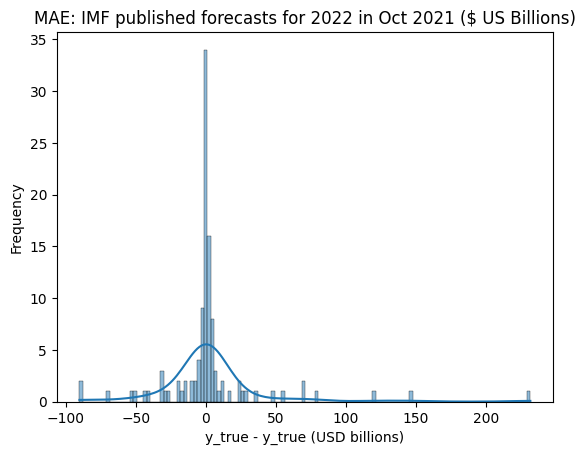

In [ ]:
imf_forecast_results_df['error'] = imf_forecast_results_df['2022'] - imf_forecast_results_df['2022_forecast']
sns.histplot(imf_forecast_results_df['error'], kde=True)
plt.xlabel('y_true - y_true (USD billions)')
plt.ylabel('Frequency')
plt.title('MAE: IMF published forecasts for 2022 in Oct 2021 ($ US Billions)')
plt.show()

#### MAPE

In [ ]:
imf_mape = error_mape(imf_forecast_results_df['2022_forecast'],
                      imf_forecast_results_df['2022'])
print('IMF MAPE = ', imf_mape)

IMF MAPE =  0.10183044664004536


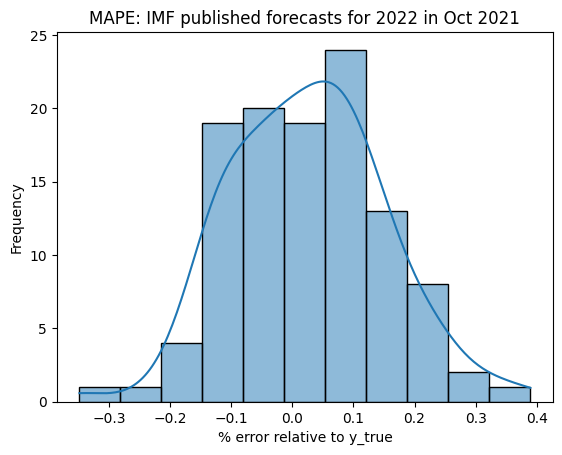

In [ ]:
imf_forecast_results_df['relative_error'] = (imf_forecast_results_df['2022'] -
                                             imf_forecast_results_df['2022_forecast'])/imf_forecast_results_df['2022']
sns.histplot(imf_forecast_results_df['relative_error'], kde=True)
plt.xlabel('% error relative to y_true')
plt.ylabel('Frequency')
plt.title('MAPE: IMF published forecasts for 2022 in Oct 2021')
plt.show()

## Visualizations

### Single country - before and after transformation

In [ ]:
country_of_choice = 'India'

#### Before

In [ ]:
# before
plot_cleaned_gdp_df = cleaned_gdp_df[cleaned_gdp_df['country'] == country_of_choice]
plot_cleaned_gdp_df

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2020,2021,2022,2023,2024,2025,2026,2027,2028,country
62,189.438,196.535,203.537,222.049,215.556,237.618,252.751,283.75,299.645,301.234,...,2671.596,3150.307,3389.689,3732.224,4105.381,4511.847,4951.615,5427.392,5944.382,India


In [ ]:
country_melted_df = pd.melt(plot_cleaned_gdp_df, id_vars=['country'], var_name='year', value_name='gdp')
country_melted_df.head()

,country,year,gdp
0,India,1980,189.438
1,India,1981,196.535
2,India,1982,203.537
3,India,1983,222.049
4,India,1984,215.556


AttributeError: ignored

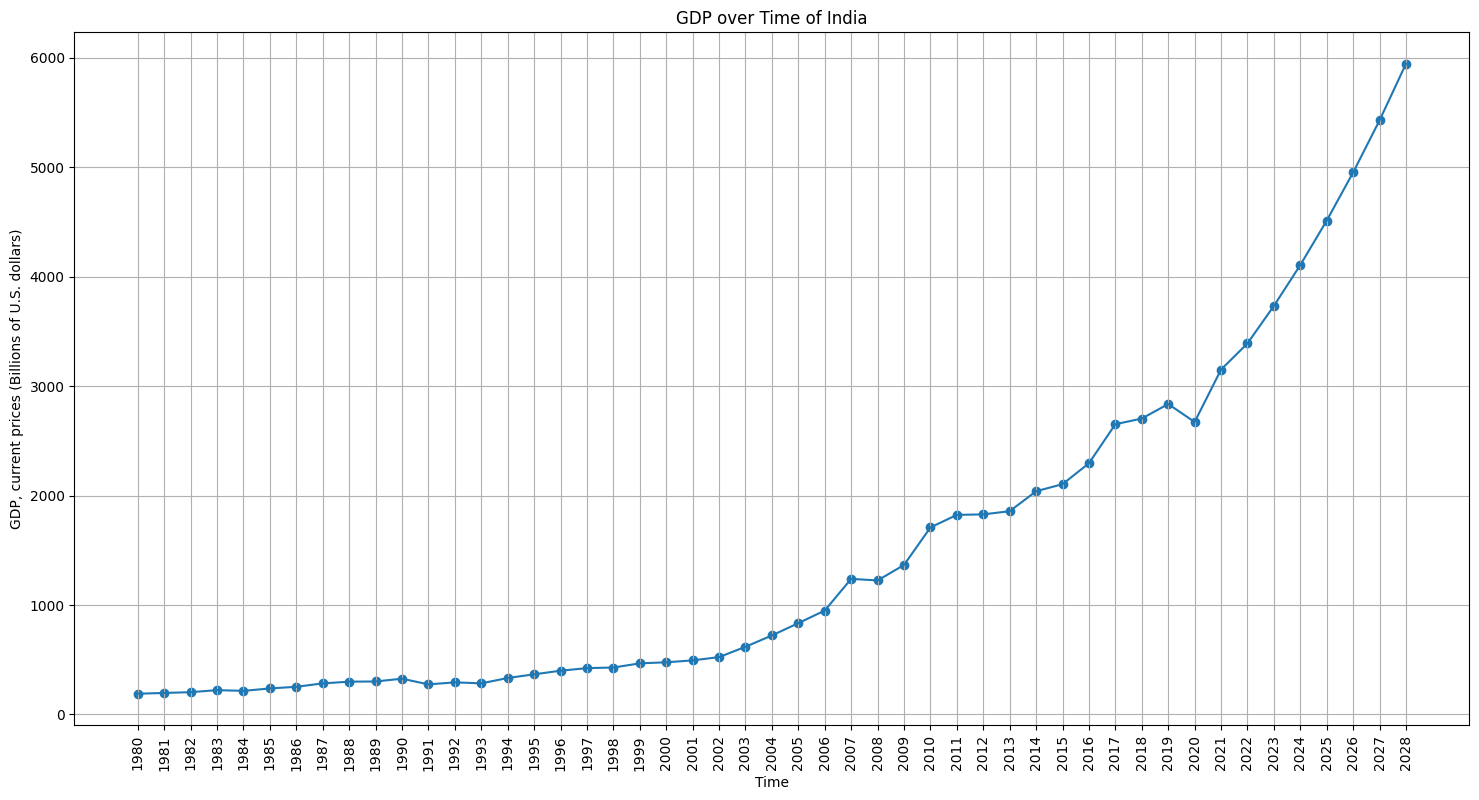

In [ ]:
plt.figure(figsize=(18, 9))
plt.plot(country_melted_df['year'], country_melted_df['gdp'])
plt.scatter(country_melted_df['year'], country_melted_df['gdp'])
plt.title(f'GDP over Time of {country_of_choice}')
plt.xlabel('Time')
plt.ylabel('GDP, current prices (Billions of U.S. dollars)')

# # Set the x-axis ticks to show every tenth value
# x_ = list(country_melted_df[['year']])
# x_ticks = x_[::2]
# print(x_ticks)
# plt.xticks(x_ticks)

plt.xticks(rotation=90)

# show a grid
plt.grid(True)
plt.figsave('gdpraw.png')

<Figure size 3600x1200 with 0 Axes>

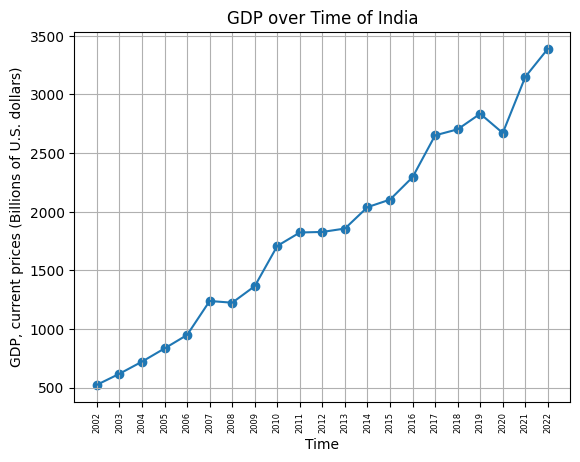

<Figure size 3600x1200 with 0 Axes>

In [ ]:
temp = country_melted_df[country_melted_df['year'].astype(int) >= 2002]
temp = temp[temp['year'].astype(int) <= 2022]

plt.plot(temp['year'], temp['gdp'])
plt.scatter(temp['year'], temp['gdp'])
plt.title(f'GDP over Time of {country_of_choice}')
plt.xlabel('Time')
plt.ylabel('GDP, current prices (Billions of U.S. dollars)')

# # Set the x-axis ticks to show every tenth value
# x_ = list(country_melted_df[['year']])
# x_ticks = x_[::2]
# print(x_ticks)
# plt.xticks(x_ticks)

plt.xticks(fontsize=6)
plt.xticks(rotation=90)

# show a grid
plt.grid(True)
plt.figure(figsize=(36, 12))

#### After

In [ ]:
# before
transformed_gdp_df = transformed_gdp_df[cleaned_gdp_df['country'] == country_of_choice]
transformed_gdp_df

,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,country
62,6.78,6.79,6.82,6.87,6.93,7.03,6.95,7.08,7.17,7.13,...,7.18,7.24,7.29,7.36,7.33,7.38,7.35,7.35,7.39,India


In [ ]:
transformed_country_melted_df = pd.melt(transformed_gdp_df, id_vars=['country'], var_name='year', value_name='gdp')
transformed_country_melted_df.head()

,country,year,gdp
0,India,2002,6.78
1,India,2003,6.79
2,India,2004,6.82
3,India,2005,6.87
4,India,2006,6.93


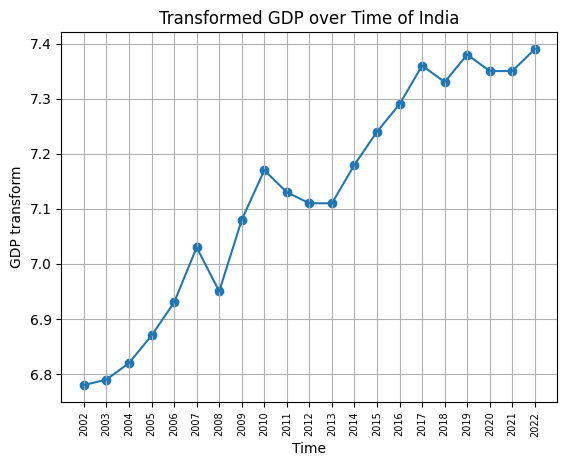

In [ ]:
plt.plot(transformed_country_melted_df['year'], transformed_country_melted_df['gdp'])
plt.scatter(transformed_country_melted_df['year'], transformed_country_melted_df['gdp'])
plt.title(f'Transformed GDP over Time of {country_of_choice}')
plt.xlabel('Time')
plt.ylabel('GDP transform')

# # Set the x-axis ticks to show every tenth value
# x_ = list(country_melted_df[['year']])
# x_ticks = x_[::2]
# print(x_ticks)
# plt.xticks(x_ticks)

plt.xticks(fontsize=7)
plt.xticks(rotation=90)

# show a grid
plt.grid(True)
plt.show()

In [ ]:
cleaned_gdp_df.tail()

,"GDP, current prices (Billions of U.S. dollars)",1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
167,Middle East and Central Asia,527.714,588.285,581.559,591.099,599.786,617.744,626.892,743.168,780.507,...,3820.148,3412.564,3995.072,4750.874,4698.168,4893.834,5168.551,5442.165,5743.487,6066.951
168,Other advanced economies,775.274,790.860,785.664,784.097,821.924,819.463,999.432,1230.294,1450.500,...,7451.982,7404.808,8568.574,8581.514,8800.731,9147.297,9605.214,10061.637,10511.283,10975.395
169,Sub-Saharan Africa,317.456,335.793,338.583,311.806,247.335,225.926,257.466,279.882,301.615,...,1768.224,1672.529,1886.949,2013.032,1957.231,2084.818,2271.584,2458.237,2654.768,2875.895
170,World,11232.069,11526.241,11310.303,11610.283,12025.117,12553.732,14793.158,17032.786,19156.083,...,87325.540,84960.903,96487.666,100135.361,104476.432,109734.270,115598.839,121580.994,127499.667,133782.888
171,"©IMF, 2023",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
